<a href="https://colab.research.google.com/github/luckyme410/summary_champ/blob/main/summarize_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## В приведенном ноутбуке мы будем суммаризировать спортивные статьи с Чемпионат.com (https://www.championat.com/). Статьи выбраны по 7 видам спорта (футбол, баскетбол, хоккей, ...). Для суммаризации текстов использовались: mT5-small и mBart-ru

In [ ]:
! pip install datasets transformers rouge-score evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=52df1cca15931d92b0ab1f7147a5b067a1fdf151c90b38fe96d58793dfde9a97
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's depend

In [ ]:
!pip install -U nltk

In [ ]:
import evaluate
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### Загрузим данные:

In [ ]:
!unzip /content/articles_championat.zip

Archive:  /content/articles_championat.zip
  inflating: content/articles_championat.csv  


In [ ]:
# Данные парсились с сайта Чемпионат.com в 2023 году.
# HTML-разметка сайта поменялась, скорее всего,
# поэтому код для парсинга не привожу, а загружаю готовые данные:
data = pd.read_csv("/content/content/articles_championat.csv") # /content/drive/MyDrive/articles_championat.csv
print('Кол-во статей:', data.shape[0])
print()
data.head()

Кол-во статей: 16047



,text,title,subtitle,date,sport
0,"В то время пока «Ред Булл» близится к тому, чт...",10 худших команд в истории Формулы-1. От дерев...,Одна из команд была связана с Советским Союзом.,"16 июля 2023, 11:30 МСК",auto
1,Авторитетный обозреватель Формулы-1 Джо Сейвуд...,"Норрис в «Феррари», Леклер в «Мерседесе»?! Раз...",Через год Формулу-1 могут подкараулить мощнейш...,"15 июля 2023, 12:30 МСК",auto
2,В марте ФИА открыла приём заявок на участие в ...,Скучаете по шинным войнам в Формуле-1? Вот 2 п...,"Хэмилтон за возвращение дуэли шинников, но это...","14 июля 2023, 12:30 МСК",auto
3,Свершилось. Ника де Вриса всё-таки уволили из ...,"8 громких случаев, когда пилоты Формулы-1 поки...",Однажды «Феррари» выгнала гонщика уже после пе...,"13 июля 2023, 16:30 МСК",auto
4,Одним из главных трансферных активов этого лет...,Звезда IndyCar рвётся в Ф-1. Но у Палоу не пол...,"Алекс, безусловно, талантлив, но выстрелить ср...","12 июля 2023, 17:00 МСК",auto


In [ ]:
# описание столбцов:

# text - статья
# title - ее заголовок
# subtitle - подзаголовок статьи
# date - дата публикации (str)
# sport - вид спорта

Нас интересуют 3 столбца: text (статья), title и subtitle. Title + subtitle и будут кратким содержанием статьи (gold standard).
Конечно заголовок и подзаголовок статьи тянут на саммари лишь с натяжкой, но тем не менее.

In [ ]:
# соединим title & subtitle:
data['title'] = data['title'].apply(lambda txt: txt + ' ' if txt[-1] in '.?!;' else txt + '. ')                               # ?????
data['summary'] = data['title'] + data['subtitle']

In [ ]:
# вот что получилось:
data['summary'].values[:10].tolist()

['10 худших команд в истории Формулы-1. От деревенских энтузиастов до «Ламборгини». Одна из команд была связана с Советским Союзом.',
 'Норрис в «Феррари», Леклер в «Мерседесе»?! Разбираем свежие трансферные слухи. Через год Формулу-1 могут подкараулить мощнейшие перестановки.',
 'Скучаете по шинным войнам в Формуле-1? Вот 2 причины, почему монополия неизбежна. Хэмилтон за возвращение дуэли шинников, но это лишь мечты.',
 '8 громких случаев, когда пилоты Формулы-1 покидали команду прямо по ходу сезона. Однажды «Феррари» выгнала гонщика уже после первого этапа.',
 'Звезда IndyCar рвётся в Ф-1. Но у Палоу не получится стать новым Монтойей и Вильнёвом. Алекс, безусловно, талантлив, но выстрелить сразу у него вряд ли получится.',
 'Действующего чемпиона затмил новичок! Оценки за Гран-при Великобритании. Макс Ферстаппен снова был совсем не идеален.',
 '«Ред Булл» выкинул чемпиона всего на свете через 10 гонок. Что это значит для рынка Ф-1? Рискованная ставка «быков» не сработала. А Перес те

### Анализ текстов:

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
%%time
# кол-во слов (токенов) в статьях:
data['text_num_tok'] = data['text'].apply(lambda txt: len(nltk.word_tokenize(txt)))

# кол-во слов (токенов) в саммари:
data['summary_num_tok'] = data['summary'].apply(lambda txt: len(nltk.word_tokenize(txt)))

CPU times: user 2min 16s, sys: 348 ms, total: 2min 16s
Wall time: 2min 20s


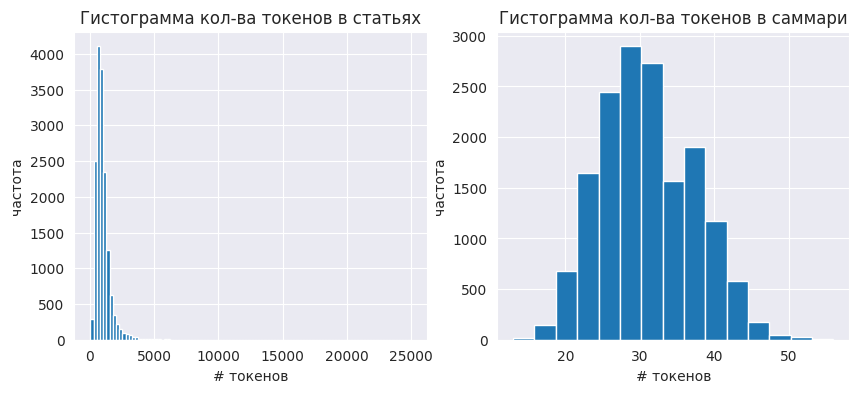

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.title('Гистограмма кол-ва токенов в статьях')
plt.hist(data['text_num_tok'], bins=100)
plt.xlabel('# токенов')
plt.ylabel('частота')

plt.subplot(122)
plt.title('Гистограмма кол-ва токенов в саммари')
plt.hist(data['summary_num_tok'], bins=15)
plt.xlabel('# токенов')
plt.ylabel('частота');

Ого, похоже у них работают фанаты Льва Николаевича... Исключим лонгриды

квантиль 0.995: 4228


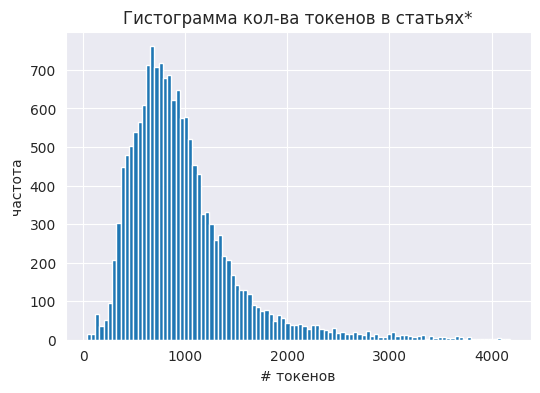

In [ ]:
# квантиль 0.995:
q995 = round(data['text_num_tok'].quantile(0.995))
print('квантиль 0.995:', q995)

# исключим лонгриды:
mask = data['text_num_tok'] <= q995

plt.figure(figsize=(6, 4))
plt.title('Гистограмма кол-ва токенов в статьях*')
plt.hist(data.loc[mask, 'text_num_tok'], bins=100)
plt.xlabel('# токенов')
plt.ylabel('частота');

Длинные статьи будут обрезаться при токенизации, поэтому не переживаем за них. Посмотрим на самые короткие:

In [ ]:
# квантиль 1%:
q01 = round(data['text_num_tok'].quantile(0.01))
print('квантиль 0.01:', q01)
print()

mask = data['text_num_tok'] <= q01
short_texts = data.loc[mask, ['text']].values.tolist()

# выберем 15 рандомных 'коротышей':
random_idx = np.random.choice(np.arange(len(short_texts)), size=15 ,replace=False)
for i in random_idx:
  print(short_texts[i][0])
  print()

квантиль 0.01: 227

26 февраля в Эр-Рияде (Саудовская Аравия) состоится грандиозный боксёрский вечер. В главном бою сразятся Джейк Пол и Томми Фьюри. Американец является известным блогером, но успел набить приличный рекорд в боксе – 6-0. Британец имеет более весомую статистику – 8-0. Он является профессиональным боксёром и братом легендарного Тайсона Фьюри.
Боксёрский вечер с главным боем Джейка Пола и Томми Фьюри стартует в 22:00 по Москве.
Официального эфира в России не планируется, но «Чемпионат» максимально полно осветит все самые интересные события боксёрского вечера.
Прогнозом на бой поделился сам чемпион WBC в супертяжёлом весе Тайсон Фьюри: «Не думаю, что бой получится быстрым. Думаю, он его измотает. Это восемь раундов, поэтому я думаю, что Томми сможет измотать его и нокаутировать в последних раундах.
Как только Томми нанесёт ему несколько сильных ударов, я посмотрю, из чего сделан Джейк Пол. Потому что, когда Томми наносит мне сильные удары, надев большие перчатки, мне стано

Короткие статьи выглядят нормально. Теперь посмотрим на корреляцию между длиной статьи и саммари:

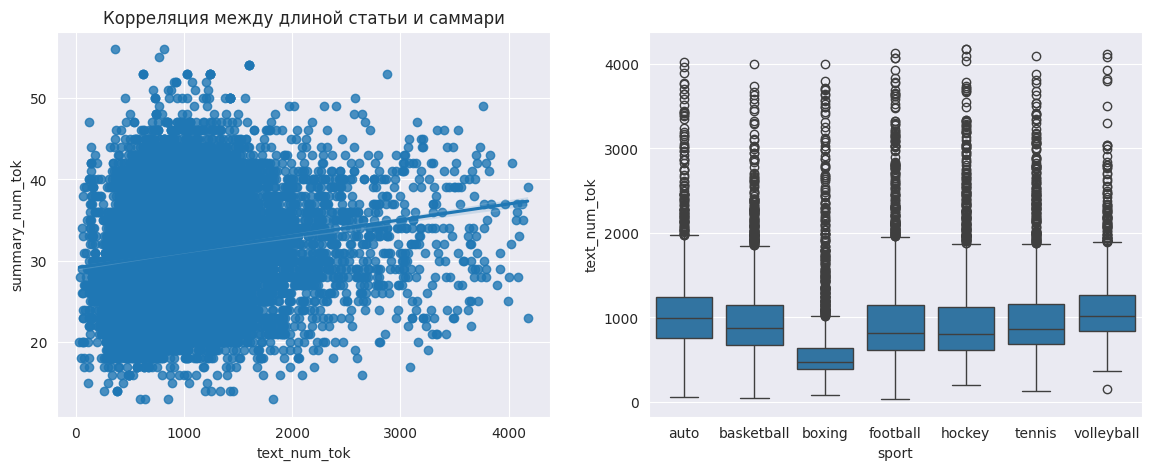

In [ ]:
# исключим лонгриды:
mask = data['text_num_tok'] <= q995

plt.figure(figsize=(14, 5))
ax1 = plt.subplot(121)
sns.regplot(data=data[mask],
            x='text_num_tok',
            y='summary_num_tok',
            ax=ax1)
plt.title('Корреляция между длиной статьи и саммари')

# длина статьи в разрезе по видам спорта:
ax2 = plt.subplot(122)
sns.boxplot(data=data[mask],
            x='sport',
            y='text_num_tok',
            ax=ax2);

Корреляция присутствует, но не очень сильная. По каждому виду спорта встречаются весьма длинные тексты. В целом про бокс статьи существенно короче.

Теперь соберем все символы встречающиеся в текстах:

In [ ]:
all_chars = set()  # все символы

for txt in data['text'].values:
  chars = set(txt)
  all_chars.update(chars)

for txt in data['summary'].values:
  chars = set(txt)
  all_chars.update(chars)

In [ ]:
print('всего символов:', len(all_chars))

всего символов: 588


In [ ]:
# красота, давайте посмотрим на них:
all_chars

{'\n',
 '\r',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|',
 '~',
 '\xa0',
 '¡',
 '£',
 '©',
 '«',
 '¬',
 '\xad',
 '¯',
 '°',
 '²',
 '·',
 'º',
 '»',
 '¼',
 '½',
 '¾',
 'É',
 'Ë',
 '×',
 'Ü',
 'ß',
 'à',
 'á',
 'ã',
 'ä',
 'ç',
 'è',
 'é',
 'ë',
 'í',
 'ñ',
 'ó',
 'ô',
 'õ',
 'ö',
 '÷',
 'ú',
 'ü',
 'ė',
 'ĸ',
 'Ł',
 'ł',
 'Š',
 'ū',
 'ų',
 'ž',
 '́',
 '̆',
 '̶',
 'ε',
 'ι',
 'κ',
 'ο',
 'ρ',
 'ς',
 'Ё',
 'Ѕ',
 'Ї',
 'Ј',
 'Џ',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 

Ого, сколько смайликов. Увидим как LLM'ки вывезут все это дело.

### Datasets:

In [ ]:
import datasets

In [ ]:
# данные будут в формате Dataset:
dataset = datasets.Dataset.from_pandas(data.loc[:, ['text', 'summary']])
dataset = dataset.shuffle(seed=9)

In [ ]:
# разделим на train/eval части:
dataset = dataset.train_test_split(test_size=0.15, shuffle=True, seed=11)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 13639
    })
    test: Dataset({
        features: ['text', 'summary'],
        num_rows: 2408
    })
})

### Качество baseline'a
В роли baseline предсказаний выберем первые 3 предложения из статьи (prediction) и сравних с саммари (gold standard)

In [ ]:
def get_baseline_preds(examples):
  # первые 3 предложения + разделитель '\n' между ними (метрики требуют)
  base_preds = ['\n'.join(nltk.sent_tokenize(doc)[:3]) for doc in examples['text']]
  # разделитель '\n' между предложениями в саммари (метрики требуют)
  base_true = ['\n'.join(nltk.sent_tokenize(doc)) for doc in examples['summary']]

  return {'base_preds': base_preds, 'base_true': base_true}

base_results =  dataset['test'].map(get_baseline_preds, batched=True)

Map:   0%|          | 0/2408 [00:00<?, ? examples/s]

In [ ]:
# вот что получилось:
base_results['base_preds'][:4]

['Для «Челси» 2022-й стал поворотным: спустя столько лет Роман Абрамович был вынужден искать для клуба нового владельца.\nПо итогам всех отборов им стал консорциум американца Тодда Боули.\nСделка по поглощению состоялась в мае, и с тех пор клуб проходит через сложный процесс трансформации – начиная с перестановок в руководстве и заканчивая пересмотром вектора развития команды.',
 'Шестой этап Формулы-1 — в непростительно субъективных оценках автора.\nВторая подряд превосходная гонка в исполнении немца.\nАккуратная работа с резиной на первом отрезке окупилась и позволила пробиться в топ-6, ну а затем Феттель прорвался на вторую строчку, опередив Леклера и Гасли.',
 'До начала Гран-при России Формулы-1, который уже в шестой раз пройдёт на «Сочи Автодроме», осталось всего несколько дней.\nУ настоящего болельщика уже забронированы авиабилеты и жильё.\nЕсли же нет — срочно торопитесь!',
 'Посмотреть все события 30 июня в Матч-центре «Чемпионата».\nВремя в материале — по Москве.\nПрограмма к

In [ ]:
# метрики качества: rouge и meteor
# качество для baseline:
result = rouge_metric.compute(predictions=base_results['base_preds'], references=base_results['base_true'], use_stemmer=True)
result.update(meteor_metric.compute(predictions=base_results['base_preds'], references=base_results['base_true']))

{k: round(100*v, 4) for k, v in result.items()}

{'rouge1': 12.8432,
 'rouge2': 2.4471,
 'rougeL': 12.5863,
 'rougeLsum': 12.7843,
 'meteor': 17.9148}

Будем сравнивать результаты mT5/ruBart с этими показателями

### Выбор модели:

In [ ]:
# models:
model_checkpoint = "google/mt5-small"
#model_checkpoint = "IlyaGusev/mbart_ru_sum_gazeta"

### Токенизация данных:

In [ ]:
from transformers import AutoTokenizer

# грузим токенизатор под выбранную модель:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# is fast:
tokenizer.is_fast

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


True

Сколько симвлов из all_chars будут непонятны для выбранного токенизатора:

In [ ]:
unk_chars = [char for char in all_chars if '<unk>' in tokenizer.convert_ids_to_tokens(tokenizer(char)["input_ids"])]
print('неизвестных символов:', len(unk_chars))
unk_chars[:10]

неизвестных символов: 32


['🛬', '🥲', '🛎', '🕘', '🕣', '🟨', '🕗', '🕦', '🕝', '🥱']

In [ ]:
#  для mT5 надо указать префикс, чтобы модель понимала какую задачу ей надо решать
if model_checkpoint in ["google/mt5-small", "google/mt5-base"]:
    prefix = "summarize: "  # 'суммировать: '  "summarize: "
else:
    prefix = ""

prefix

'summarize: '

In [ ]:
# токенизируем статьи и саммари:

# максимальное число токенов для статьи/саммари
max_input_length = 512 # 1024
max_target_length = 128

def preprocess_function(examples):
    # добавим prefix
    examples['text'] = [prefix + doc for doc in examples["text"]]
    # input_ids + attention_mask:
    model_inputs = tokenizer(examples['text'], max_length=max_input_length, truncation=True)

    # labels:
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# обработаем данные батчами:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/13639 [00:00<?, ? examples/s]

Map:   0%|          | 0/2408 [00:00<?, ? examples/s]

In [ ]:
# prefix + text:
for i in range(3):
  print(tokenized_datasets['train']['text'][i][:128])

summarize: На молодёжном чемпионате мира по хоккею в Галифаксе и Монктоне завершилась четвертьфинальная стадия. Групповой этап п
summarize: 8 января в матче 12-го тура российской женской Суперлиги краснодарское «Динамо» на своей площадке уверенно победило «
summarize: 20:45. Андрей Воронцевич после матча удивил сообщением о том, что тренерский штаб, помимо тренировочной работы, собра


In [ ]:
# удалим текстовые данные + __index_level_0__
drop_columns = ['text', 'summary']
if '__index_level_0__' in tokenized_datasets['test'].features.keys():
  drop_columns.append('__index_level_0__')

tokenized_datasets = tokenized_datasets.remove_columns(drop_columns)

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13639
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2408
    })
})

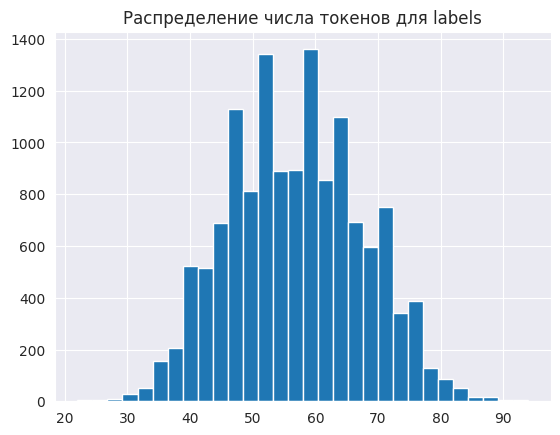

In [ ]:
# заценим распределение числа токенов в labels
# прикинем сколько токенов генерить для предсказаний (max_new_tokens и min_new_tokens):
labels_num_tok = list(map(len, tokenized_datasets['train']['labels']))

plt.hist(labels_num_tok, bins=30)
plt.title('Распределение числа токенов для labels');

35-80 токенов должно хватить, т.е. max_new_tokens=80, min_new_tokens=35

### Импорт модели + data_collator

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, MT5ForConditionalGeneration #, Seq2SeqTrainingArguments, Seq2SeqTrainer

# импорт модели:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
#model = MT5ForConditionalGeneration.from_pretrained(model_checkpoint)

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Т.к. данные подаются в модель параллельно, они должны быть одной длины.
Добить input_ids/labels pad_token'ми до одной длины нам поможет data_collator, кроме того, он заменит pad_token'ы на -100 в labels чтобы loss их игнорил, прям как ты свою бывшую (бывшего)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

### Dataloaders:

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE=8

In [ ]:
train_loader = DataLoader(tokenized_datasets['train'],
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=data_collator)


test_loader = DataLoader(tokenized_datasets['test'],
                          batch_size=2*BATCH_SIZE,
                          shuffle=False,
                          collate_fn=data_collator)

In [ ]:
# работает ли?
for x_batch in test_loader:
  break
{k: v.shape for k,v in x_batch.items()}

{'input_ids': torch.Size([16, 512]),
 'attention_mask': torch.Size([16, 512]),
 'labels': torch.Size([16, 70]),
 'decoder_input_ids': torch.Size([16, 70])}

In [ ]:
# -100 в labels:
x_batch['labels'][:2]

tensor([[  4716,  19340,    433, 145524,    507, 101678,  15566,    279,    259,
            668,  10994,    401,  12601,  10263,    260,  32452,   1633,  43325,
            946, 118289,   2007, 113722,    748,    315,    404, 220586,   4832,
           1836,    259,  15088,    259,   4150,  13703,   2007,  32409,   6148,
          63235,  98808,    259,    279,    892,    259,    324,  23390,   6824,
          27492, 163269,  20593,    260,      1,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100],
        [  3461,   1348,  45315,    261,  19973,   4599,   1436,    291,    259,
          52911,    817,  18361,    995,   1311,  11167,    661,    259,  15354,
           1285,    605,    309,    983,  55421,    657,    374,  96331,    264,
          16296,    259, 140839,    308,    260,    867,  91288,  19138,   4229,
          44829,   1008,  75149,    261,   

### Метрики качества:
Оценивать качество сгенерированного текста будем по двум метрикам: rouge и meteor.

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Replace -100 in the predictions as we can't decode them.
    #predictions = [np.where(l != -100, l, tokenizer.pad_token_id) for l in predictions]
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = [np.where(l != -100, l, tokenizer.pad_token_id) for l in labels]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Add mean generated length
    #prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    #result["gen_len"] = np.mean(prediction_lens)

    result.update(meteor_metric.compute(predictions=decoded_preds, references=decoded_labels))
    return {k: round(100*v, 4) for k, v in result.items()}

### Model to GPU/CPU:

In [ ]:
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

In [ ]:
# device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

### Оценим кач-во модели без fine-tuning'а

In [ ]:
# eval:
datasets = {'test': test_loader}
#_ = 0

model.eval()
for name, dataset in datasets.items():
  eval_pred = []
  eval_true = []
  for x_batch in tqdm(dataset):
    #_ += 1
    x_batch = {k: v.to(device) for k,v in x_batch.items()}
    with torch.no_grad():
      output = model.generate(**{k: v for k,v in x_batch.items() if k in ('input_ids', 'attention_mask')},
                             max_new_tokens=80,
                             min_new_tokens=35,
                             num_beams=2)

    y_pred = output.cpu().numpy()
    y_true = x_batch['labels'].cpu().numpy()
    eval_pred.extend(y_pred)
    eval_true.extend(y_true)

    #if _ == 50:
    #  break

  # evaluate metrics:
  scores = compute_metrics((eval_pred, eval_true))
  print(model_checkpoint)
  print(scores)

100%|██████████| 151/151 [05:52<00:00,  2.33s/it]


google/mt5-small
{'rouge1': 1.5974, 'rouge2': 0.3387, 'rougeL': 1.5818, 'rougeLsum': 1.6051, 'meteor': 5.9725}


In [ ]:
#                                    google/mt5-small:
# {'rouge1': 1.5974, 'rouge2': 0.3387, 'rougeL': 1.5818, 'rougeLsum': 1.6051, 'meteor': 5.9725}


In [ ]:
# примеры генерации текста на последнем батче:
text_gen = tokenizer.batch_decode(y_pred, skip_special_tokens=True)

In [ ]:
text_gen

['<extra_id_0> СКА снова в плей-офф. СКА снова в плей-офф. СКА снова в плей-офф. СКА снова в плей-офф',
 '<extra_id_0> и почему. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг.',
 '<extra_id_0> и почему? Это и есть именно так. Это и есть именно так. Это и есть именно так.',
 '<extra_id_0> не зря. Читать далее → Читать далее → Читать далее → Читать далее → Читать далее → Читать далее →',
 '<extra_id_0> оказался лучшим результатом встречи с «Акроном». Футболисты «Спартак» перед матчем с «Акроном» снова',
 '<extra_id_0> на финал чемпионата мира по хоккею-2023 наступила пора решающих матчей. ФОТО: ИНТЕРНЕТ-ФОНД.РФ. <extra_id_9>',
 '<extra_id_0> точно. UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284',
 '<extra_id_0> Грин. Что хозяева стали: «Лейкерс» против 1 из 20 (55%). «Лейкерс» против 1 из 20 (55%).']

Результаты ниже плинтуса, попробуем их улучшить

### Fine-tuning модели:
Используем обучающую выборку для настройки моделей на генерацию заголовков в стиле Чемпионат.com

In [ ]:
# optimizer:
optim = AdamW(params=model.parameters(), lr=3e-4, weight_decay=0.01)

In [ ]:
# scheduler:
# линейно уменьшаем темп обучения (lr)
N_epochs = 1
n_train_steps = len(train_loader) * (N_epochs + 1)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optim,
    num_warmup_steps=0,
    num_training_steps=n_train_steps)

In [ ]:
# train/eval loops:
loss_hist = [] # train loss history
#eval_loss_hist = [] # train loss history
N_samples_eval = len(test_loader)
N_samples_train = len(train_loader)

for epoch in range(1, N_epochs+1):
  train_loss = 0
  model.train()
  for x_batch in tqdm(train_loader):
    # to device:
    x_batch = {k: v.to(device) for k,v in x_batch.items()}

    optim.zero_grad()
    output = model(**x_batch)
    output['loss'].backward()
    # clip grads:
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optim.step()

    # get and save loss:
    loss = output['loss'].detach().cpu().item()
    loss_hist.append(loss)
    train_loss += loss

    # scheduler step:
    lr_scheduler.step()

  #_ = 0

  # eval:
  eval_pred = []
  eval_true = []
  model.eval()
  for x_batch in tqdm(test_loader):
    #_ += 1
    x_batch = {k: v.to(device) for k,v in x_batch.items()}
    with torch.no_grad():
      output = model.generate(**{k: v for k,v in x_batch.items() if k in ('input_ids', 'attention_mask')},
                              max_new_tokens=80,
                              min_new_tokens=35,
                              num_beams=2
      )
    y_pred = output.cpu().numpy()
    y_true = x_batch['labels'].cpu().numpy()
    eval_pred.extend(y_pred)
    eval_true.extend(y_true)

    #if _ == 50:
    #  break
  # evaluate metrics:
  scores = compute_metrics((eval_pred, eval_true))

  print(f'\nepoch: {epoch}')
  print(f'train loss: {round(train_loss/N_samples_train, 5)}')
  print(scores)
  print()

  0%|          | 0/1705 [00:00<?, ?it/s]Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

100%|██████████| 151/151 [05:41<00:00,  2.26s/it]



epoch: 1
train loss: 4.81669
{'rouge1': 5.1901, 'rouge2': 1.0491, 'rougeL': 5.1649, 'rougeLsum': 5.1805, 'meteor': 12.9171}



качество суммаризации не очень, но прогресс, в сравнении с тем что было до fine-tuning'а очевиден.

In [ ]:
#                                          google/mt5-small:
# epoch: 1
# train loss: 4.81669
# {'rouge1': 5.1901, 'rouge2': 1.0491, 'rougeL': 5.1649, 'rougeLsum': 5.1805, 'meteor': 12.9171}


# epoch: 2
# train loss: 3.80835
# {'rouge1': 5.4517, 'rouge2': 1.1386, 'rougeL': 5.4611, 'rougeLsum': 5.4181, 'meteor': 13.098}

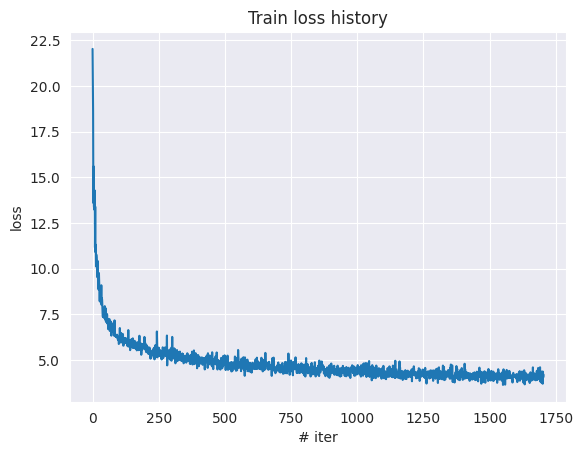

In [ ]:
plt.plot(loss_hist)
plt.title('Train loss history')
plt.xlabel('# iter')
plt.ylabel('loss');

Примеры генерации заголовков

In [ ]:
# примеры генерации текста из последнего батча:
text_gen = tokenizer.batch_decode(y_pred, skip_special_tokens=True)

In [ ]:
# google/mt5-small:
text_gen

['«Динамо» и «Динамо» уже не будет. Российские команды и московские армейцы уже давно не хватают шансы на Западе КХЛ.',
 '«Зенита» и «Зенит» снова вышел в истории «Зенита». «Зенит» вышел в истории «Зенита» в истории «Зенита».',
 'Уэйн уже не побил рекорд Гретцки. Российские звезды всё равно не могут набрать рекорд в 50 голов за сезон. Российские звезды уже не смогли выйти на втором месте.',
 '«Феррари» и «Феррари» не может пойти в финале сезона. Даниил Квята не может пойти в карьере.',
 'У «Спартака» снова выбил красно-белых из Кубка России. «Спартак» снова выбил «Спартака». «Спартак» снова снова снова испортил «Спартак».',
 '«ЧМ-2023» будет смотреть на финал чемпионата мира по хоккею. В этом матче будет смотреть трансляцию. Что будет смотреть на финал чемпионата мира по хоккею на ЧМ-2023.',
 'Уайт и его детище уже не было шансов. Российский чемпион может стать лучшим бойцем. Российский чемпион может стать лучшим бойцем.',
 '«Лейкерс» и «Лейкерс» выиграли в плей-офф НХЛ. «Лейкерс» уже 

In [ ]:
# сделать больше эпох, обрезать градиенты, подобрать гиперпараметры оптимизатора и scheduler'a ...
# To be continued...

Качество модели получилось низким, это связано с тем, что решаемая задача больше относится к генерации заголовков, а не к саммари статей.
Заголовки с большой натяжкой можно отождествить саммари, тем не менее, в качестве упражнения - ок.